In [ ]:
#| default_exp graph_builder
from nbdev.showdoc import *
import numpy as np
from tqdm.notebook import trange, tqdm
import matplotlib.pyplot as plt
import torch
import torch_geometric
%load_ext autoreload
%autoreload 2

# Graph Builder
> Construct a directed graph from points in a flow field

This is the second fundamental piece of FEARFRED. The FlowGenerator creates a vector field and a distribution on it, but it is this graph builder which constructs samples from the vector field into a directed graph, in order to feed the GNN discriminator.

Presently, we assume that the points are densely enough sampled that we can connect points a and b based solely on 
1. the distance between a and b
2. the flow at point a

Namely, we can connect them using the *flashlight kernel* developed in our other work.

# The Flashlight Cosine Similarity

A flow-based dot product, defined as

$$
\langle x_{i}, x_{j}\rangle_{f} = \frac{\langle x_{j} - x_{i}, v_{i} \rangle}{\text{max}(\epsilon, \|x_{j} - x_{i}\|\|v_{i}\|)}
$$

The following code implements a pairwise flashlight cosine similarity for batches of data.

For high-dimensional data, using the flashlight cosine similarity may be all that is needed to create a directed graph, as the sparsity of any high-dimensional manifold makes it unlikely that anything except nearby points would fall into the beam of the flow's "flashlight."

In [ ]:
#| export
def directions_array_from(X):
    """Given n x d tensor X, returns n x n tensor where entry i,j is x_j - x_i. Useful for getting a distance matrix."""
    n1 = X.shape[0]
    P2 = X[:, :, None].repeat(1, 1, n1)
    P1 = X.T.repeat(n1, 1, 1)
    P3 = P1 - P2
    P3 = P3.transpose(1, 2)
    return P3
def flashlight_cosine_similarity(X, flow, directions_array = None, eps = 0.01):
    """Computes a localized cosine similarity between the direction xj - xi and the flow at xi. Ideal for use in embedding spaces."""
    # Get directions array of xj - xi
    if directions_array is not None:
        P3 = directions_array
    else:
        P3 = directions_array_from(X)
    # expand array of flows
    flows_expanded = flow.repeat(len(X),1,1).transpose(dim0=0,dim1=1)
    # get norms of each array
    norm_flows = torch.linalg.norm(flows_expanded,dim=2)
    norm_directions = torch.linalg.norm(P3,dim=2)
    # Perform dot product
    dot_prod = (P3 * flows_expanded).sum(dim=2)
    # normalize by norms
    cosine_sim = dot_prod / (torch.max(torch.tensor(eps),norm_flows * norm_directions))
    return cosine_sim


Here's how it looks for a point in the middle of this field

/Users/adjourner/Projects/FEARFRED/FEARFRED/plotting.py:23: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(X[:, 0], X[:, 1], marker=".", c=labels, cmap=cmap, alpha=alpha_points)


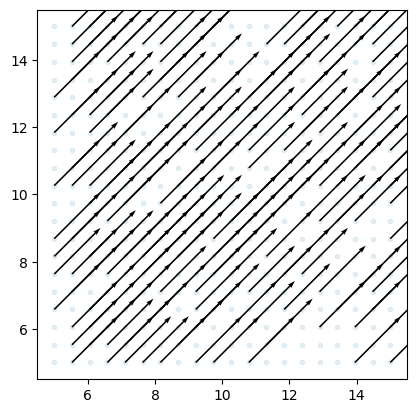

In [ ]:
import numpy as np
from FEARFRED.plotting import plot_directed_2d
flow = torch.tensor([[1,1]]).float()
x, y = np.meshgrid(np.linspace(-5,5,20),np.linspace(-5,5,20))
x = torch.tensor(x,dtype=float).cpu()
y = torch.tensor(y,dtype=float).cpu()
xy_t = torch.concat([x[:,:,None],y[:,:,None]],dim=2).float() + 10
flows = flow.repeat(len(xy_t)**2,1)
directions_array = xy_t.reshape(400,2)
plot_directed_2d(directions_array, flows)

<matplotlib.image.AxesImage>

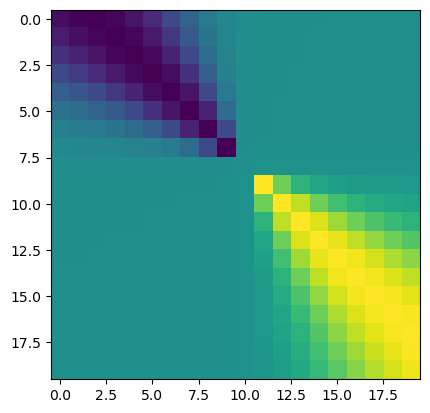

In [ ]:
affs_local_cos = flashlight_cosine_similarity(directions_array,flows)
affinities_square = affs_local_cos[170].reshape(20,20)
plt.imshow(affinities_square**11)

# The Flashlight Affinity Matrix

For data in a *really* low dimension (e.g. 2), we need to incorporate distance into our affinity calculations. We do this pretty simply - by multiplying a standard distance-based kernel with our flashlight cosine similarity.

$$
K_{f}(x_{i},x_{j},v_{i}) = \exp{(1 - \langle x_{i}, x_{j} \rangle_{f}^{strength}})*K(x_{i},x_{j})
$$


In [ ]:
#| export
import torch
import numpy as np
def anisotropic_kernel(D, sigma=0.7, alpha = 1):
    """Computes anisotropic kernel of given distances matrix.

    Parameters
    ----------
    D : ndarray or sparse
    sigma : float, optional
      Kernel bandwidth, by default 0.7
    alpha : int, optional
      Degree of density normalization, from 0 to 1; by default 1
    This is a good function.
    """
    W = torch.exp(-D**2/(2*sigma**2))
    # Additional normalization step for density
    D = torch.diag(1/(torch.sum(W,dim=1)**alpha)) 
    W = D @ W @ D
    return W
def adaptive_anisotropic_kernel(D, k=10, alpha = 1):
    # Get the distance to the kth neighbor
    distance_to_k_neighbor = np.partition(D,k)[:,k]
    # Populate matrices with this distance for easy division. 
    div1 = np.ones(len(D))[:,None] @ distance_to_k_neighbor[None,:]
    div2 = div1.T
    # compute the gaussian kernel with an adaptive bandwidth
    W = (1/2*np.sqrt(2*np.pi))*(np.exp(-D**2/(2*div1**2))/div1 + np.exp(-D**2/(2*div2**2))/div2)
    # Additional normalization step for density
    D = np.diag(1/(np.sum(W,axis=1)**alpha)) 
    W = D @ W @ D
    return W

In [ ]:
#| export
import torch
def flashlight_kernel(X, flows, kernel_type = "fixed", k=10, sigma = 0.7, anisotropic_density_normalization = 1, flow_strength=1):
    """A distance aware adaptation of the flashlight cosine similarity, 
    obtained by multiplying the cosine similarity by a traditional guassian kernel.
    This is not intended to be differentiable, although is with some choices of kernels (anisotropic, plain).
    """
    # Get flashlight cosine
    DA = directions_array_from(X)
    W_cosine = flashlight_cosine_similarity(X, flows, directions_array=DA)
    # Flow strength must be an odd integer to be symmetric
    assert flow_strength == int(flow_strength) and flow_strength // 2 != flow_strength /2
    W_strengthened_cosine = W_cosine ** flow_strength
    D = torch.linalg.norm(DA, dim=-1)
    if kernel_type == "anisotropic":
        W = anisotropic_kernel(D, sigma=sigma, alpha=anisotropic_density_normalization) # works with pytorch tensors, is theoretically differentiable.
    if kernel_type == "adaptive anisotropic":
        D_np = D.numpy()
        W_np = adaptive_anisotropic_kernel(D_np, k=k, alpha = anisotropic_density_normalization)
        W = torch.tensor(W_np)
    if kernel_type == "fixed":
        W = (1/((2*torch.pi)**0.5*sigma))*torch.exp(-D/(2*sigma**2))
        W = W.fill_diagonal_(0)
    flashlight_K = W * torch.exp(W_strengthened_cosine-1)
    return flashlight_K

In [ ]:
from FEARFRED.datasets.manifolds import directed_circle
X, flows, labels = directed_circle(num_nodes=128)
X = torch.tensor(X)
flows = torch.tensor(flows)
labels = torch.tensor(labels)

<matplotlib.image.AxesImage>

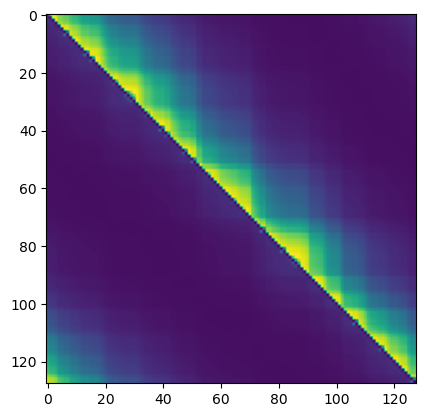

In [ ]:
A = flashlight_kernel(X,flows,sigma=0.7)
plt.imshow(A)

In [ ]:
A

tensor([[0.0000, 0.5334, 0.5271,  ..., 0.0649, 0.0719, 0.0720],
        [0.0723, 0.0000, 0.5633,  ..., 0.0610, 0.0674, 0.0675],
        [0.0714, 0.0762, 0.0000,  ..., 0.0603, 0.0667, 0.0668],
        ...,
        [0.4761, 0.4445, 0.4391,  ..., 0.0000, 0.5124, 0.5114],
        [0.5304, 0.4959, 0.4900,  ..., 0.0695, 0.0000, 0.2508],
        [0.5314, 0.4968, 0.4909,  ..., 0.0694, 0.1746, 0.0000]],
       dtype=torch.float64)

In [ ]:
torch.max(A)

tensor(0.5637, dtype=torch.float64)